# Group 2 Project: Used Cars

## Description to run the notebook:

### After downloading the vehicles.csv file, the file needs to be put into the same folder which holds our project (and have the name "vehicles.csv"). Our csv reader assumes that the file is directly accessible from the same folder, and needs to see it, otherwise it'll throw an error. From there, all cells can be ran as normal. (NOTE: Our dataset has approximately 450,000 entries, so the file is 1.4 Gigabytes and will take some time to upload to jupyter lab and read).

In [4]:
import math
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error
#Creating a function to collect the relative absolute error
def relative_absolute_error(a, b):
    meanabs = mean_absolute_error(a, b)
    a_mean = np.mean(a)
    return meanabs/(mean_absolute_error(a, np.full(a.shape, a_mean)))
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from typing import Dict
import csv
from typing import NamedTuple
from scipy.spatial import distance
from collections import defaultdict
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor


Vector = List[float]
pd.options.mode.chained_assignment = None 

In [5]:
# The car dataset in its original form before any testing
original = pd.read_csv("vehicles.csv", engine = "python", encoding = "latin1")

In [6]:
#########
#Extracting the input features from the original dataset
usedcars = original[["price", "year", "manufacturer", "condition", "cylinders", "odometer", "title_status", "transmission", "drive", "type", "model"]]
#########

In [7]:
#Consider only values which don't have a null value
newUsedCars = usedcars.dropna()

#Find outliers within the dataset to reduce extremeities and skewness
def find_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df.drop(df[(df[column] < lower_bound)].index, inplace = True)
    df.drop(df[(df[column] > upper_bound)].index, inplace = True)
    
find_outliers_iqr(newUsedCars, 'price')
find_outliers_iqr(newUsedCars, 'odometer')
find_outliers_iqr(newUsedCars, 'year')

##Turns string to int value for relevant input features
le = LabelEncoder()
newUsedCars['conditionint'] = le.fit_transform(newUsedCars['condition'])
newUsedCars["title_statusint"] = le.fit_transform(newUsedCars["title_status"])
newUsedCars["transmissionint"] = le.fit_transform(newUsedCars["transmission"])
newUsedCars["manufacturerint"] = le.fit_transform(newUsedCars["manufacturer"])
newUsedCars["cylindersint"] = le.fit_transform(newUsedCars["cylinders"])
newUsedCars["driveint"] = le.fit_transform(newUsedCars["drive"])
newUsedCars["typeint"] = le.fit_transform(newUsedCars["type"])
newUsedCars["modelint"] = le.fit_transform(newUsedCars["model"])

# Data Visualization

## Bar Charts for categorical variables and their mean prices

<Axes: title={'center': 'Prices by Condition'}, xlabel='condition'>

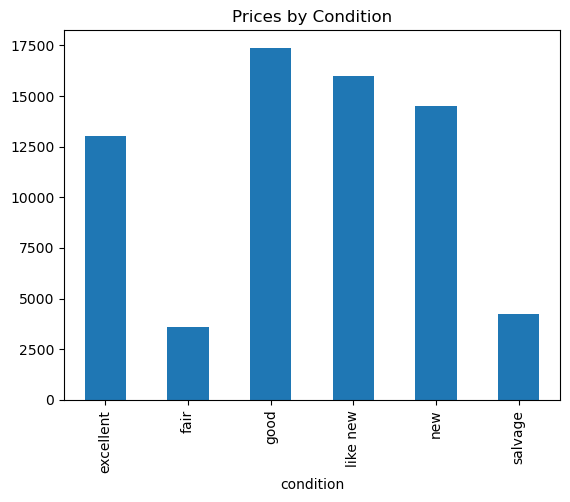

In [10]:
newUsedCars.groupby(["condition"])["price"].mean().plot(kind="bar", title="Prices by Condition")

#### As seen by this graph, the mean value of a car generally decreases as its condition gets worse, though one exception are cars in "good" condition, which has a slightly higher mean price than the other categories. This could be the result of most of the cars in the dataset having the "good" condition applied to them compared to the others

<Axes: title={'center': 'Prices by Car Status'}, xlabel='title_status'>

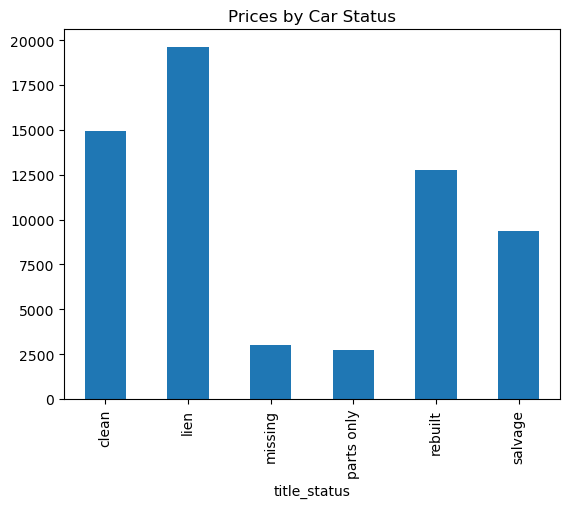

In [12]:
newUsedCars.groupby(["title_status"])["price"].mean().plot(kind="bar", title="Prices by Car Status")

#### The results from this graph are as expected, with cars that are more complete and finished being more valuable. Cars with a lien status ont hem are sold off at even higher prices than the rest, though the means are still closer together

<Axes: title={'center': 'Prices by Transmission Type'}, xlabel='transmission'>

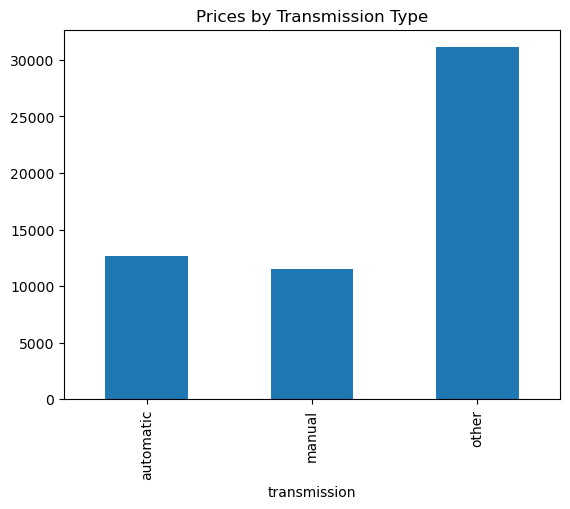

In [14]:
newUsedCars.groupby(["transmission"])["price"].mean().plot(kind="bar", title="Prices by Transmission Type")

#### There isn't much difference between the mean prices of the types of transmissions, though cars with alternative transmissions are more valuable overall.

<Axes: title={'center': 'Prices by Manufacturer'}, xlabel='manufacturer'>

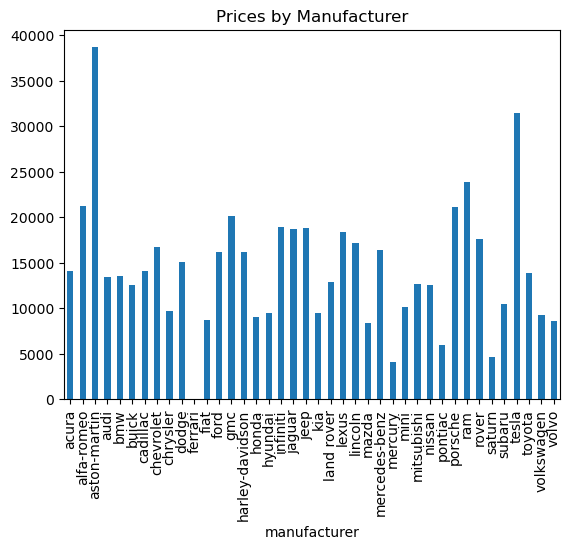

In [16]:
newUsedCars.groupby(["manufacturer"])["price"].mean().plot(kind="bar", title="Prices by Manufacturer")

#### There are strong differences among the mean prices of cars by their manufacutrer. Generally more high-class manufactuers like Alfa-Romeo and Aston-Martin are far more valuable than more general car manufacturers like Chevrolet and Ford.

<Axes: title={'center': 'Prices by Number of Cylinders'}, xlabel='cylinders'>

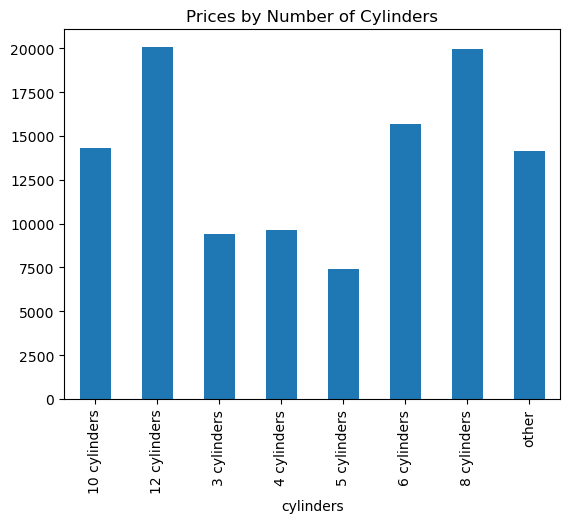

In [18]:
newUsedCars.groupby(["cylinders"])["price"].mean().plot(kind="bar", title="Prices by Number of Cylinders")

#### Though both 10-cylinder and 5-cylinder cars break from this trend, the mean price of a car generally increases as the number of cylinders increases giving a somewhat linear relationship between cylinders and prices.

<Axes: title={'center': 'Prices by Their Type of Drive'}, xlabel='drive'>

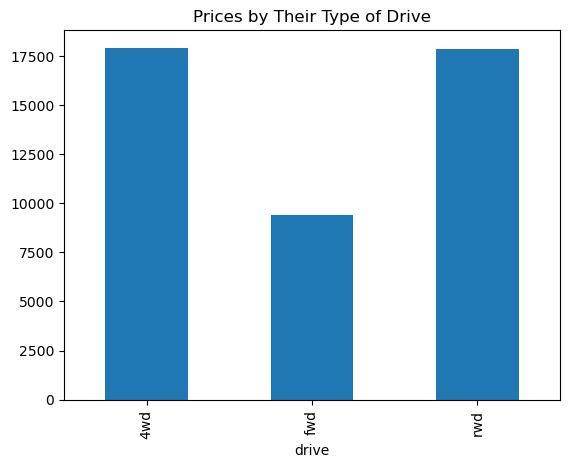

In [20]:
newUsedCars.groupby(["drive"])["price"].mean().plot(kind="bar", title="Prices by Their Type of Drive")

#### Cars which have a forward wheel drive have far lower mean prices than cars with a rear wheel or 4 wheel drive

<Axes: title={'center': 'Prices by the type of car'}, xlabel='type'>

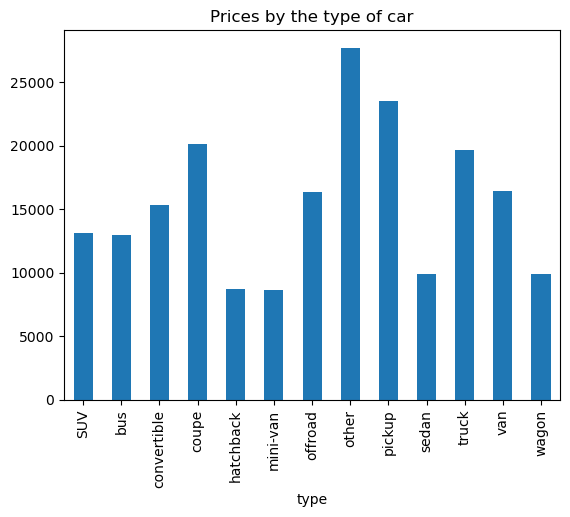

In [22]:
newUsedCars.groupby(["type"])["price"].mean().plot(kind="bar", title="Prices by the type of car")

#### Mean prices differ heavily based on what type a specific car is, ranging from hatchbacks and mini-vans to coupes and pickups, the differences in types should be a good indicator of a specific car's value.

## Exploration of independent sellers vs businesses on Cragislist

In [25]:
vehicles = original.copy() # Creating a copy to preserve the
vehicles = vehicles.dropna(subset=['description', 'price', 'odometer', 'manufacturer', 'model']) 
find_outliers_iqr(vehicles, 'price')
find_outliers_iqr(vehicles, 'odometer')
find_outliers_iqr(vehicles, 'year')
vehicles = vehicles.drop_duplicates(subset=['description'], keep='first')
ogDf = vehicles.copy()
carvana = vehicles[vehicles['description'].str.contains("Carvana", case=False, na=False)]
dealership = vehicles[vehicles['description'].str.contains("dealership", case=False, na=False)]
newCar =  vehicles[
    vehicles["description"].str.contains("new car", case=False, na=False) &
    ~vehicles["description"].str.contains("like new", case=False, na=False)
]
finance = vehicles[vehicles['description'].str.contains("financing available", case=False, na=False)]

combined_indices = newCar.index.union(carvana.index).union(finance.index).union(dealership.index)
vehicles = vehicles.drop(combined_indices)
vehicles = vehicles.reset_index(drop=True)
carvana = carvana.reset_index(drop=True)
newCar = newCar.reset_index(drop=True)
finance = finance.reset_index(drop=True)
dealership = dealership.reset_index(drop=True)
usedDealerShips = pd.concat([carvana, dealership, newCar, finance], ignore_index=True)


In [26]:
print(f"Dataset size (Bar duplicates and null values): {ogDf.shape[0]}")
print(f"Vehicles listed by Carvana: {carvana.shape[0]}")
print(f"Dealership vehicles: {dealership.shape[0]}")
print(f"New cars (excluding 'like new'): {newCar.shape[0]}")
print(f"Vehicles with financing available: {finance.shape[0]}")
print(f"Remaining vehicles after removing combined indices: {vehicles.shape[0]}")
print(f"Original dataset size: {original.shape[0]}")

Dataset size (Bar duplicates and null values): 319593
Vehicles listed by Carvana: 61550
Dealership vehicles: 124295
New cars (excluding 'like new'): 6898
Vehicles with financing available: 20961
Remaining vehicles after removing combined indices: 176310
Original dataset size: 426880


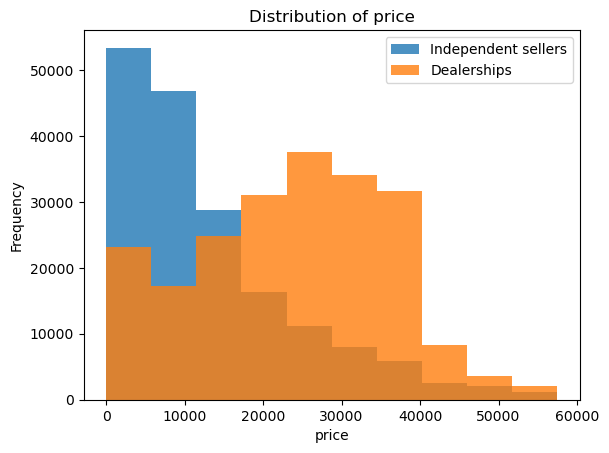

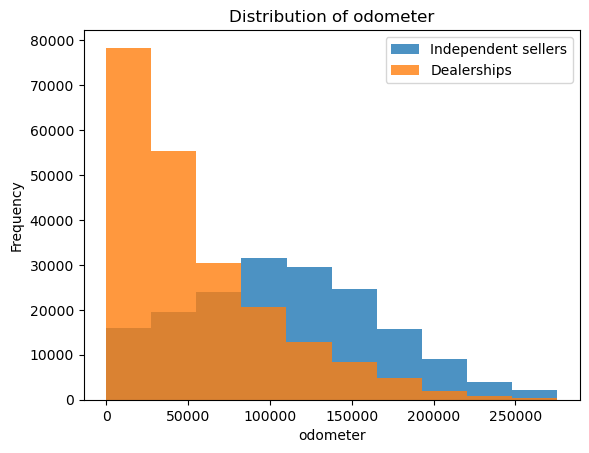

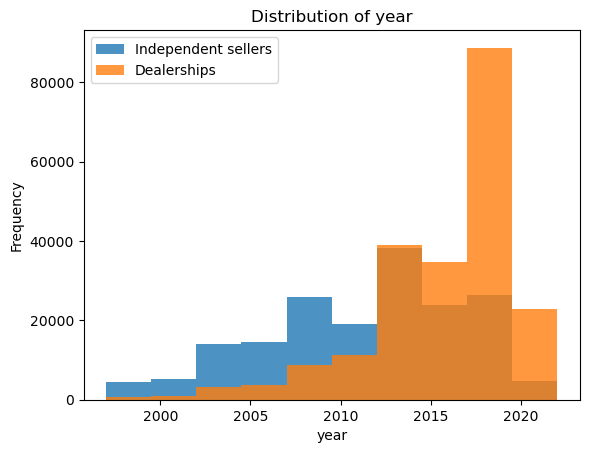

In [27]:
iterable = ['price', 'odometer', 'year']
for i in iterable:
    plt.hist(vehicles[i], label = "Independent sellers", alpha=0.8)
    plt.hist(usedDealerShips[i], label = "Dealerships", alpha=0.8)
    plt.title(f'Distribution of {i}')
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## The histograms for year, price, and year indicate skew. For dealerships, the distibution of year of cars is skewed left but independent sellers aren't as skewed. The distribution of odometer is also heavily skewed by dealerships but right this time instead of left. The distribution of odometer isn't heavily skewed in entries by independent sellers. In the distribution of price we see the opposite. The distribution of price in entries by independent sellers are skewed right heavily but dealerships is not skewed.

In [29]:
dfs = [vehicles, usedDealerShips, ogDf, original, newUsedCars]
dfNames = [ 'Dataset of cars sold by independent sellers (with outliers removed, without duplicates and null values for certain features kept)',
           'Dataset of cars sold by dealerships (with outliers removed, without duplicates and null values for certain features kept)',
           "Data set with both sellers (with outliers removed, without duplicates and null values for certain features kept)",
           "Dataset in it's original state",
           "Data set with outliers removed and all null values for all features removed"]
for i in dfs:
    i['conditionint'] = le.fit_transform(i['condition'])
    i["title_statusint"] = le.fit_transform(i["title_status"])
    i["transmissionint"] = le.fit_transform(i["transmission"])
    i["manufacturerint"] = le.fit_transform(i["manufacturer"])
    i["modelint"] = le.fit_transform(i["model"])
    i["cylindersint"] = le.fit_transform(i["cylinders"])
    i["driveint"] = le.fit_transform(i["drive"])
    i["typeint"] = le.fit_transform(i["type"])
for df, name in zip(dfs, dfNames):
    print(f"\nAnalysis for: {name}\n")

    # Correlation matrix
    print("Correlation with 'price':")
    correlation_matrix = df[['price', 'odometer', 'conditionint', 'title_statusint', 'transmissionint', 
                              'manufacturerint', 'cylindersint', 'driveint', 'typeint', 'modelint']].corr()
    print(correlation_matrix['price'].sort_values(ascending=False))
    
    # Standard deviation
    dev = df[['price', 'odometer', 'year', 'conditionint', 'title_statusint', 'transmissionint', 
                  'manufacturerint', 'cylindersint', 'driveint', 'typeint', 'modelint']].std()
    print("\nStandard Deviation:")
    print(dev)
    
    # Covariance matrix
    covariance_matrix = df[['price', 'odometer', 'year', 'conditionint', 'title_statusint', 'transmissionint', 
                             'manufacturerint', 'cylindersint', 'driveint', 'typeint', 'modelint']].cov()
    print("\nCovariance with 'price':")
    print(covariance_matrix['price'])
    # Variance
    variance = df[['price', 'odometer', 'year', 'conditionint', 'title_statusint', 'transmissionint', 
                   'manufacturerint', 'cylindersint', 'driveint', 'typeint', 'modelint']].var()
    print("\nVariance:")
    print(variance)
    print("\n----------------------------------------------------------------------------------------------------\n")


Analysis for: Dataset of cars sold by independent sellers (with outliers removed, without duplicates and null values for certain features kept)

Correlation with 'price':
price              1.000000
cylindersint       0.114372
conditionint       0.087694
modelint           0.053489
typeint           -0.004813
transmissionint   -0.006597
title_statusint   -0.033773
manufacturerint   -0.040921
driveint          -0.153523
odometer          -0.388453
Name: price, dtype: float64

Standard Deviation:
price              11453.073214
odometer           58702.726281
year                   5.414926
conditionint           2.571863
title_statusint        1.192325
transmissionint        0.396204
manufacturerint       10.919954
cylindersint           1.976019
driveint               1.202378
typeint                4.724781
modelint            3988.630680
dtype: float64

Covariance with 'price':
price              1.311729e+08
odometer          -2.611672e+08
year               2.887995e+04
conditioni

#### Outliers were excluding using IQR earlier, so it was omitted from this analysis. The raw data is basically useless due to noisy data. Correlation is generally highest magnitude with odometer, transimission, and sometimes cylinders. Price has the highest varaince followed by odometer, price and year. Covariance is high for odometer and model. Covariance is not as high but still moderate for year and cylinders. Standard deviation for price and odometer are fairly large numbers and are consistent through the data sets. 

## Scatterplots for relationship between quantitative variables and car prices

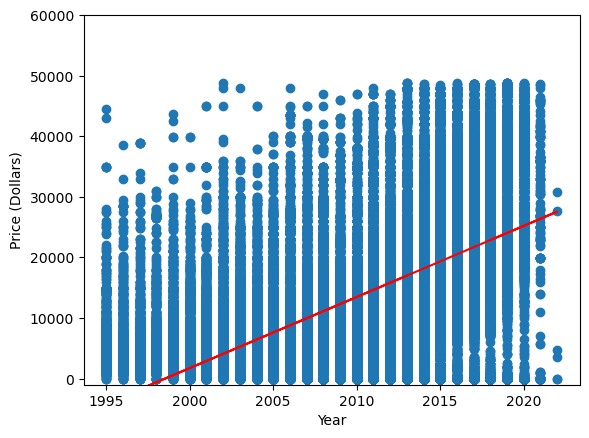

In [32]:
#Setting up a scatter plot between the year and the price
fig, ax = plt.subplots()
year = newUsedCars["year"]
price = newUsedCars["price"]
ax.scatter(year, price)

# Creating a regression line to show the trend

m, b = np.polyfit(year, price, deg=1)
ax.plot(year, m * year + b, color="red")

#labels
plt.xlabel("Year")
plt.ylabel("Price (Dollars)")

# setting the limits to make it easy to view
plt.ylim(-1000, 60000)
plt.show()
#plt.xlim(1900, 2022)

#### Looking at this graph, there seems to be a slightly positive relationship between the year and the price. There is a strong positve linear relationship between the age of a car and its price, showing that age is a good indicator of price and a valuable input for our model.

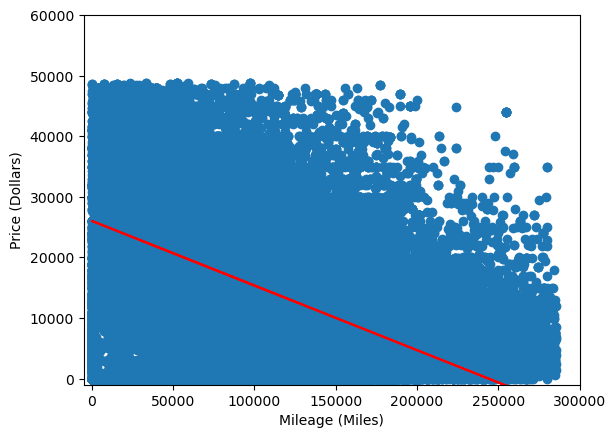

In [34]:
#Setting up a scatter plot between the mileage and the price
fig, ax = plt.subplots()
mileage = newUsedCars["odometer"]
price = newUsedCars["price"]

#plotting the line
ax.scatter(mileage, price)

# Creating a regression line to show the trend
m, b = np.polyfit(mileage, price, deg=1)
ax.plot(mileage, m * mileage + b, color="red")

#labels
plt.xlabel("Mileage (Miles)")
plt.ylabel("Price (Dollars)")

# setting the limits to make it easy to view
plt.ylim(-1000, 60000)
plt.xlim(-5000, 300000)
plt.show()

#### Unlike the relationship between the year and the price, the relationship between the mileage of a car and its price is negative, meaning that the more a car has been driven, the lower its price becomes. The strongly downward sloping nature of the regression line means mileage is a valuable metric to judge a car's price

## Heat Map of Correlations

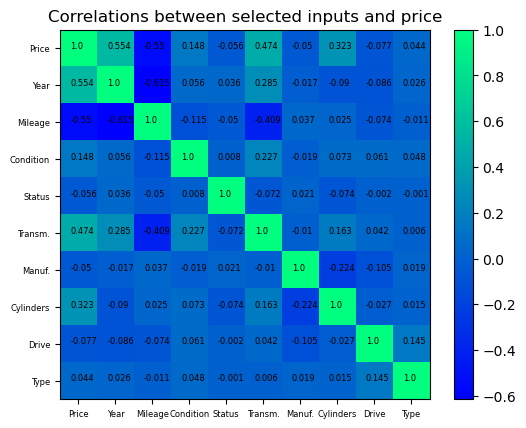

In [37]:

#Correlating each relevant category with others
correlations = newUsedCars[["price", "year", "odometer", "conditionint", "title_statusint", "transmissionint", "manufacturerint", "cylindersint", "driveint", "typeint"]].corr()
#Setting the axes up (Transm. = Transmission and Manuf. = Manufacturer, reduced to avoid word overlap)
ax = plt.axes()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(["Price", "Year", "Mileage", "Condition", "Status", "Transm.", "Manuf.", "Cylinders", "Drive", "Type"], fontsize = 6)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yticklabels(["Price", "Year", "Mileage", "Condition", "Status", "Transm.", "Manuf.", "Cylinders", "Drive", "Type"], fontsize = 6)

#Setting the title
plt.title("Correlations between selected inputs and price")
plt.imshow(correlations, cmap="winter")
plt.colorbar()
#Putting the actual correlation coefficients with their respective correlation
for i in range(10):
    for j in range(10):
        plt.annotate(str(round(correlations.values[i][j], 3)), xy=(j - 0.225, i), fontsize=6)

#### The correlation matrix shows which inputs have the most impact on price and, as a result, which inputs will be the most valuable to improving our dataset. Variables with a higher absolute correlation, like the Year and Mileage, have a far greater impact on predictions than less correlative variables like the Status and Manufacturer of the car

## Box Plot for price

Text(0.5, 1.0, 'Boxplot for the price of used cars')

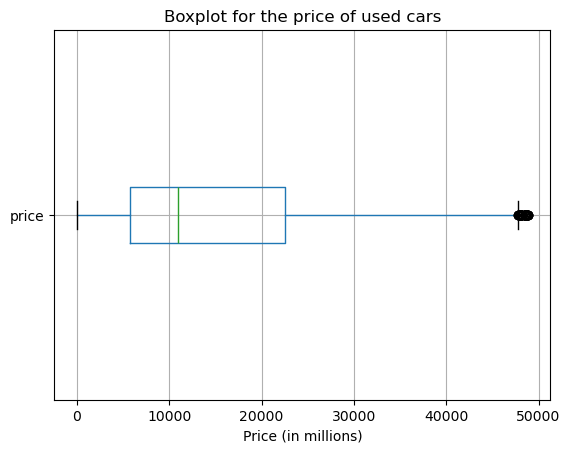

In [40]:
newUsedCars.boxplot(column=["price"], vert=False, xlabel="Price (in millions)")
plt.title("Boxplot for the price of used cars")

#### As shown by the boxplot, when major outliers are removed from the data set, the price of most cars tends to sit in the 10,000 to 20,000 dollar range. The data is somewhat skewed right, but not to a troubling extent that can get in the way of accurate testing.

# Model Creation and Evaluation

# -------------------------Polynomial Regression (Roshan)------------------------------
#### For my progression, I initially started with both a Quadratic and Cubic model which tested the 2 original inputs, the year and mileage, then the four best inputs (year, mileage, transmission, number of cylinders), and finally all inputs. Throughout my progress, I compared and contrasted the accuracy between both the models while seeing the rate at which each model developed and improved. The testing for Polynomial Regression is split into the Quadratic and Cubic model, with each model split into three with the different set of inputs used for each model.

### Two Original Inputs - Quadratic

In [45]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)

In [46]:
## Quadratic Regression Model

PolyRegress = PolynomialFeatures(2)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)

#### Evaluation

In [48]:
print(f'Root mean squared error: {root_mean_squared_error(testerY, testerYPredictions)}')
print(f'Mean absolute error: {mean_absolute_error(testerY, testerYPredictions)}')
print(f'R-Squared: {r2_score(testerY, testerYPredictions)}')
print(f'Relative absolute error: {relative_absolute_error(testerY, testerYPredictions)}')
print(f'Correlation Coefficients: {polyM.coef_}')

Root mean squared error: 8969.599314456687
Mean absolute error: 6581.536632185826
R-Squared: 0.4180520875709087
Relative absolute error: 0.6762789683588968
Correlation Coefficients: [ 0.00000000e+00 -1.29292496e+05  1.86905940e-01  3.23609645e+01
 -1.67654274e-04  3.97747499e-07]


### Four Best Inputs - Quadratic

In [50]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer", "transmissionint", "cylindersint"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)

In [51]:
## Quadratic Regression Model

PolyRegress = PolynomialFeatures(2)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)

#### Evaluation

In [53]:
print(f'Root mean squared error: {root_mean_squared_error(testerY, testerYPredictions)}')
print(f'Mean absolute error: {mean_absolute_error(testerY, testerYPredictions)}')
print(f'R-Squared: {r2_score(testerY, testerYPredictions)}')
print(f'Relative absolute error: {relative_absolute_error(testerY, testerYPredictions)}')
print(f'Correlation Coefficients: {polyM.coef_}')

Root mean squared error: 7487.958275466191
Mean absolute error: 4983.848798834967
R-Squared: 0.5944308987558471
Relative absolute error: 0.5121102126287876
Correlation Coefficients: [ 0.00000000e+00 -1.36329627e+05  1.19375011e+00  5.53023910e+05
 -3.54792553e+05  3.39548229e+01 -6.17545982e-04 -2.74782309e+02
  1.74572179e+02  1.08469976e-07 -1.94933390e-02 -3.44383906e-03
  4.10997235e+02  6.81897625e+02  8.28922055e+02]


### All Inputs - Quadratic

In [55]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer", "conditionint", "title_statusint", "transmissionint", "manufacturerint", "cylindersint", "driveint", "typeint"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)
 

In [56]:
## Quadratic Regression Model

PolyRegress = PolynomialFeatures(2)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)


#### Evaluation

In [58]:
print(f'Root mean squared error: {root_mean_squared_error(testerY, testerYPredictions)}')
print(f'Mean absolute error: {mean_absolute_error(testerY, testerYPredictions)}')
print(f'R-Squared: {r2_score(testerY, testerYPredictions)}')
print(f'Relative absolute error: {relative_absolute_error(testerY, testerYPredictions)}')
print(f'Correlation Coefficients: {polyM.coef_}')

Root mean squared error: 7133.442602120093
Mean absolute error: 4703.585966255184
R-Squared: 0.6319249573378529
Relative absolute error: 0.4833120960370624
Correlation Coefficients: [ 5.52151609e-01 -1.01753206e+05  2.49172108e+00 -1.15647242e+05
  3.47269598e+04  5.06887907e+05 -3.34857938e+03 -2.67164190e+05
  3.07966959e+05 -1.19909075e+04  2.54080885e+01 -1.26001747e-03
  5.77331986e+01 -1.70068948e+01 -2.52691286e+02  1.65300405e+00
  1.31784906e+02 -1.55695557e+02  5.91572467e+00  8.73405952e-08
 -4.47910800e-03  3.09007127e-03 -1.32717139e-02  2.04882759e-04
 -5.44235081e-03 -6.76011247e-03  1.96464884e-03 -2.13419169e+02
 -8.98296049e+01  2.23352577e+03 -6.51942741e+00  1.30650132e+02
 -2.76315037e+01  2.08835960e+01 -2.09984183e+02 -1.83946315e+02
  3.52273629e-01 -3.16502320e+01 -1.28344183e+02 -4.24402842e+00
 -3.50430486e+02  1.51425238e+01  4.05519471e+02  3.51075394e+02
 -1.53053353e+02  6.04097730e-01  6.42382034e+00  1.67938938e+01
 -2.19804672e+00  5.70031173e+02 -6.84

### Two Original Inputs - Cubic

In [60]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)

In [61]:
## Cubic Regression Model

PolyRegress = PolynomialFeatures(3)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)

### Evaluation

In [63]:
print(f'Root mean squared error: {root_mean_squared_error(testerY, testerYPredictions)}')
print(f'Mean absolute error: {mean_absolute_error(testerY, testerYPredictions)}')
print(f'R-Squared: {r2_score(testerY, testerYPredictions)}')
print(f'Relative absolute error: {relative_absolute_error(testerY, testerYPredictions)}')
print(f'Correlation Coefficients: {polyM.coef_}')

Root mean squared error: 8965.139443275908
Mean absolute error: 6569.119832008411
R-Squared: 0.4186306568884042
Relative absolute error: 0.675003092938978
Correlation Coefficients: [ 0.00000000e+00 -6.21449621e-02  7.99152422e-01 -3.13992395e+01
  2.28797043e-03 -2.68367396e-05  1.04902588e-02 -1.37282094e-06
  1.35529157e-08  4.89192020e-15]


### Four Best Inputs - Cubic

In [65]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer", "transmissionint", "cylindersint"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)

In [66]:
## Cubic Regression Model

PolyRegress = PolynomialFeatures(3)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)

### Evaluation

In [68]:
print(f'Root mean squared error: {root_mean_squared_error(testerY, testerYPredictions)}')
print(f'Mean absolute error: {mean_absolute_error(testerY, testerYPredictions)}')
print(f'R-Squared: {r2_score(testerY, testerYPredictions)}')
print(f'Relative absolute error: {relative_absolute_error(testerY, testerYPredictions)}')
print(f'Correlation Coefficients: {polyM.coef_}')

Root mean squared error: 7502.42029854494
Mean absolute error: 4998.976531457721
R-Squared: 0.5928627773618798
Relative absolute error: 0.5136646470995606
Correlation Coefficients: [-1.49138360e+01  6.86069805e+01  1.45559650e+01  4.65842211e-01
 -1.30093635e-01 -7.32677456e+01 -1.47586394e-02  4.78500080e+02
 -1.28086064e+02  8.93002131e-06 -5.90703812e+00 -1.02806184e+00
  4.55967342e-01  1.22294649e+00 -1.79803769e-01  2.43116748e-02
  3.74325890e-06 -2.39585484e-01  6.27167610e-02 -4.63198291e-09
  2.93428055e-03  5.09083547e-04  5.93725874e-01  2.26278566e+00
  3.92907169e-01  1.29318778e-12  1.81909526e-07 -5.82746240e-09
 -7.85370563e-03 -9.15560290e-03  3.68573607e-04  4.19862202e-01
  1.79711790e+01 -4.47053472e+02  8.89115158e+00]


### All Inputs - Cubic

In [70]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer", "conditionint", "title_statusint", "transmissionint", "manufacturerint", "cylindersint", "driveint", "typeint"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)

In [71]:
## Cubic Regression Model

PolyRegress = PolynomialFeatures(3)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)


### Evaluation

In [73]:
print(f'Root mean squared error: {root_mean_squared_error(testerY, testerYPredictions)}')
print(f'Mean absolute error: {mean_absolute_error(testerY, testerYPredictions)}')
print(f'R-Squared: {r2_score(testerY, testerYPredictions)}')
print(f'Relative absolute error: {relative_absolute_error(testerY, testerYPredictions)}')
print(f'Correlation Coefficients: {polyM.coef_}')

Root mean squared error: 6990.765339731776
Mean absolute error: 4564.342690539608
R-Squared: 0.6465015795910221
Relative absolute error: 0.4690042977044762
Correlation Coefficients: [ 5.70737307e+00 -1.07317070e+01  4.07944580e+01 -9.84147830e-02
  1.10089989e-02  3.70184859e-01 -1.31087938e-02 -1.05578629e-01
  2.07269449e-01  1.45722672e-02 -2.42068267e+01 -3.66733071e-02
 -1.03279176e+02  7.94964462e+00  3.71384842e+02 -1.19442394e+01
 -1.04940021e+02  2.09283350e+02  1.32184960e+01 -7.93082529e-06
  9.09865578e-01  1.86468134e-01 -3.58111408e+00  1.60440921e-01
 -5.58686533e-01 -1.07341515e+00 -4.13429479e-01 -1.81680457e-01
  9.97431886e-02  3.02225853e-01  1.60993041e+00 -4.21530206e-01
  8.57934216e-02 -2.06999415e-01  9.13592576e-02  3.98816622e-02
 -4.31827117e-01  9.27846681e-02  7.93560179e-02  3.18508163e-03
  3.08086629e-01  2.47763549e+00  1.01007643e+00  3.32020388e-01
  4.81303813e-01 -1.14673202e+00 -1.86652059e+00  1.44704869e+00
  2.60447081e-01 -3.76536348e-01  3.26

## Conclusions

* When both the Quadratic and Cubic models had very few inputs, originally only the age and mileage, they fit poorly, having an R-squared value below 0.5, but both models performed well as more inputs were added
* Even inputs with lower correlation values can still contribute to greater accuracy, both the Quadrtaic and Cubic models improved their accuracy tremendously when they had more inputs to work with regardless of the strength of correlation
* Neither this model nor the quadratic model ran into overfitting the training dataset, meaning both the number of inputs and the degree of the model were low enough to keep the training set as a good indicator for testing.
* Cubic regression outperformed Quadratic regression with all inputs, and vice versa for only four inputs, calling into consideration the impacts of the degree hyperparameter
* This could indicate that Cubic regression is better for studying a dataset with a large array of inputs than Quadratic regression, but fewer inputs would be better handled by Quadratic regression


# -------------------------------Lasso Regression (Rachel)-------------------------------

For Lasso Regression I will create two models, one with all features and one with only the features with high correlations to price.

The 3 features with the most correlation are:

    Mileage
    Transmission
    Year



In [196]:
lass = Lasso()
lass.fit(trainerX, trainerY)
lassPredict = lass.predict(testerX)

## Evaluation

### All features
With Lasso, changes within the hyperparameter (alpha) will not yield many difference in the values. Because of this, I will be using different features and analyze the difference that they yeild. 

In [235]:
print("Lasso Regression with all features:")
print()
print("R-squared:", r2_score(testerY, lassPredict))
print("Mean Absolute Error:",  mean_absolute_error(testerY, lassPredict))
print("Root Mean Squared Error:", root_mean_squared_error(testerY, lassPredict))
print("Correlation Coefficient:",  np.corrcoef(testerY, lassPredict)[0, 1])
print("Relative Absolute Error:", (np.sum(np.abs(testerY - lassPredict)) /np.sum(np.abs(testerY - np.mean(testerY)))))

Lasso Regression with all features:

R-squared: 0.5549269909635473
Mean Absolute Error: 5464.271638336739
Root Mean Squared Error: 7844.163087189135
Correlation Coefficient: 0.7449363683614051
Relative Absolute Error: 0.5614755630676874


### 3-Best Features
Through sklearns KBest package I am going to refine and limit the features I use.

In [231]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=3)
X_new = selector.fit_transform(Inputs, Price)

selected_feature_indices = selector.get_support(indices=True)

selected_feature_names = [Inputs.columns[i] for i in selected_feature_indices]

featuresS = pd.DataFrame(X_new, columns = [selected_feature_names])

rtrainerX, rtesterX, rtrainerY, rtesterY = train_test_split(featuresS, Price, test_size=0.2, random_state=27)

rlass = Lasso()
rlass.fit(rtrainerX, rtrainerY)

rlassPredict = rlass.predict(rtrainerX)
rlassPredict = rlass.predict(rtesterX)

print(f"Lasso Regression with 3-Best features ({selected_feature_names}):")
print()
print("R-squared:", r2_score(rtesterY, rlassPredict))
print("Mean Absolute Error:",  mean_absolute_error(rtesterY, rlassPredict))
print("Root Mean Squared Error:", root_mean_squared_error(rtesterY, rlassPredict))
print("Correlation Coefficient:",  np.corrcoef(rtesterY, rlassPredict)[0, 1])
print("Relative Absolute Error:", (np.sum(np.abs(rtesterY - rlassPredict)) /np.sum(np.abs(rtesterY - np.mean(rtesterY)))))


Lasso Regression with 3-Best features (['year', 'odometer', 'transmissionint']):

R-squared: 0.44320035327118945
Mean Absolute Error: 6500.271223876731
Root Mean Squared Error: 8773.65314431692
Correlation Coefficient: 0.6657612435848301
Relative Absolute Error: 0.6679286256401801




**My theory that less criterias would lead to a higher R-Squared value was wrong.**

My finding with Lasso Regression is that there is a 55% accuracy with this models output. Because Lasso experiences hardly any changes when tuning is done though the changing of hyperparameters, I will not be changing the alpha in attempts to make the model more accurate.


# ------------Decision tree Regression (Bilal)------------

In [80]:
x = newUsedCars[['odometer']]
y = newUsedCars['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
RTModel = DecisionTreeRegressor(random_state=27)
RTModel.fit(X_train, y_train)
y_pred = RTModel.predict(X_test)

print(f'Root mean squared error: {root_mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'R-Squared: {r2_score(y_test, y_pred)}')
print(f'Relative absolute error: {relative_absolute_error(y_test, y_pred)}')
print(f'Correlation Coefficients: {RTModel.feature_importances_}')

Root mean squared error: 8204.3650915522
Mean absolute error: 4796.204098863348
R-Squared: 0.5131132173932726
Relative absolute error: 0.4928289761627868
Correlation Coefficients: [1.]


In [81]:
x = newUsedCars[['odometer', 'year', 'modelint']]
y = newUsedCars['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
RTModel = DecisionTreeRegressor(random_state=27)
RTModel.fit(X_train, y_train)
y_pred = RTModel.predict(X_test)

print(f'Root mean squared error: {root_mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'R-Squared: {r2_score(y_test, y_pred)}')
print(f'Relative absolute error: {relative_absolute_error(y_test, y_pred)}')
print(f'Correlation Coefficients: {RTModel.feature_importances_}')

Root mean squared error: 6098.655066045668
Mean absolute error: 2775.037885764917
R-Squared: 0.7309666184587225
Relative absolute error: 0.2851461388764879
Correlation Coefficients: [0.49264399 0.16733482 0.34002119]


In [82]:
x = newUsedCars[['odometer', 'year', 'modelint', 'transmissionint', 'manufacturerint']]
y = newUsedCars['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
RTModel = DecisionTreeRegressor(random_state=27)
RTModel.fit(X_train, y_train)
y_pred = RTModel.predict(X_test)

print(f'Root mean squared error: {root_mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'R-Squared: {r2_score(y_test, y_pred)}')
print(f'Relative absolute error: {relative_absolute_error(y_test, y_pred)}')
print(f'Correlation Coefficients: {RTModel.feature_importances_}')

Root mean squared error: 5930.099888446131
Mean absolute error: 2658.0393123462804
R-Squared: 0.7456322511632253
Relative absolute error: 0.2731240718497577
Correlation Coefficients: [0.45539901 0.14997847 0.24989517 0.07748638 0.06724097]


In [83]:
x = newUsedCars[['odometer', 'year', 'modelint', 'transmissionint', 'manufacturerint', 'cylindersint']]
y = newUsedCars['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
RTModel = DecisionTreeRegressor( random_state=27)
RTModel.fit(X_train, y_train)
y_pred = RTModel.predict(X_test)

print(f'Root mean squared error: {root_mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'R-Squared: {r2_score(y_test, y_pred)}')
print(f'Relative absolute error: {relative_absolute_error(y_test, y_pred)}')
print(f'Correlation Coefficients: {RTModel.feature_importances_}')

Root mean squared error: 5818.421879194198
Mean absolute error: 2622.839840353494
R-Squared: 0.7551227473372715
Relative absolute error: 0.2695071866242547
Correlation Coefficients: [0.44810427 0.15767972 0.14369768 0.07340819 0.05625814 0.120852  ]


#### The decision tree regression model performed quite well on the data set. As more input features were added the performance increased quite a lot. The decision tree regression model is quite suitable for this dataset.

In [85]:
x = newUsedCars[['odometer', 'year', 'modelint', 'transmissionint', 'manufacturerint', 'cylindersint', 'driveint']]
y = newUsedCars['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
RTModel = DecisionTreeRegressor(random_state=27)
RTModel.fit(X_train, y_train)
y_pred = RTModel.predict(X_test)

print(f'Root mean squared error: {root_mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'R-Squared: {r2_score(y_test, y_pred)}')
print(f'Relative absolute error: {relative_absolute_error(y_test, y_pred)}')
print(f'Correlation Coefficients: {RTModel.feature_importances_}')

Root mean squared error: 5796.79375547989
Mean absolute error: 2593.3316224385458
R-Squared: 0.7569398696064253
Relative absolute error: 0.2664751003068983
Correlation Coefficients: [0.44029305 0.15983286 0.12935325 0.073971   0.04396402 0.1160468
 0.03653902]


In [86]:
x = newUsedCars[['odometer', 'year', 'modelint', 'transmissionint', 'manufacturerint', 'cylindersint', 'driveint']]
y = newUsedCars['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
RTModel = DecisionTreeRegressor(max_depth=26, min_samples_split=18, min_samples_leaf=9,random_state=27)
RTModel.fit(X_train, y_train)
y_pred = RTModel.predict(X_test)
            
print(f'Root mean squared error: {root_mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'R-Squared: {r2_score(y_test, y_pred)}')
print(f'Relative absolute error: {relative_absolute_error(y_test, y_pred)}')
print(f'Correlation Coefficients: {RTModel.feature_importances_}')

Root mean squared error: 5696.52632223209
Mean absolute error: 3256.319480303787
R-Squared: 0.7652755955538312
Relative absolute error: 0.33459972979827457
Correlation Coefficients: [0.43613093 0.16752495 0.10214933 0.08277057 0.03706175 0.13293599
 0.04142649]


In [87]:
x = usedDealerShips[['odometer', 'year','modelint', 'transmissionint', 'manufacturerint',  "cylindersint"]]
y = usedDealerShips['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
RTModel = DecisionTreeRegressor(max_depth=23, min_samples_split=27, min_samples_leaf=5, random_state=27)
RTModel.fit(X_train, y_train)
y_pred = RTModel.predict(X_test)

print(f'Root mean squared error: {root_mean_squared_error( y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'R-Squared: {r2_score(y_test, y_pred)}')
print(f'Relative absolute error: {relative_absolute_error(y_test, y_pred)}')
print(f'Correlation Coefficients: {RTModel.feature_importances_}')

Root mean squared error: 6458.610852031295
Mean absolute error: 2990.8896520100907
R-Squared: 0.7365683840033153
Relative absolute error: 0.28952629623441734
Correlation Coefficients: [0.42234995 0.10049128 0.21932112 0.02696485 0.09597889 0.13489391]


In [88]:
x = vehicles[['odometer', 'year','modelint', 'transmissionint', 'manufacturerint']]
y = vehicles['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
RTModel = DecisionTreeRegressor(max_depth=23, min_samples_split=23, min_samples_leaf=7,random_state=27)
RTModel.fit(X_train, y_train)
y_pred = RTModel.predict(X_test)
print(f'Root mean squared error: {root_mean_squared_error( y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'R-Squared: {r2_score(y_test, y_pred)}')
print(f'Relative absolute error: {relative_absolute_error(y_test, y_pred)}')
print(f'Correlation Coefficients: {RTModel.feature_importances_}')

Root mean squared error: 7215.480374620165
Mean absolute error: 4220.970387562891
R-Squared: 0.59924441751391
Relative absolute error: 0.4755410094645875
Correlation Coefficients: [0.20068201 0.35248253 0.35365775 0.00490806 0.08826965]


#### When compared between the 3 datasets with different preprocessing, it performed the best on the data set where no distinction was made between independent sellers and dealerships. The data set where it performed the best was also the dataset where duplicate descriptions were not removed which could be a factor on why predictive modeling is better on the dataset. The dataset with entries that are likely from dealerships performed better than the dataset with independent sellers. This can indicate that the dealerships use the input features in their pricing decisions to a larger extent.

# ---------------------------------------------Multiple Linear Regression (Sai)----------------------------------

In [91]:
# Define features and target variable
x = newUsedCars[['odometer', 'year', 'modelint', 'transmissionint', 'manufacturerint', 'cylindersint', 'driveint']]
y = newUsedCars['price']


In [92]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)


In [93]:
# Initialize the multiple regression model
multi_reg_model = LinearRegression()

# Train the model
multi_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = multi_reg_model.predict(X_test)

Root Mean Squared Error: 7876.990913041586
Mean Absolute Error: 5484.817133350917
R-Squared: 0.5511939343893323
Relative Absolute Error: 0.5635866940921146
Coefficients:
{'odometer': -0.04922775277929659, 'year': 766.2885402208683, 'modelint': 0.008817141404506401, 'transmissionint': 3785.7726388848114, 'manufacturerint': 38.842352754832284, 'cylindersint': 3111.1924988930887, 'driveint': -933.2556469956284}


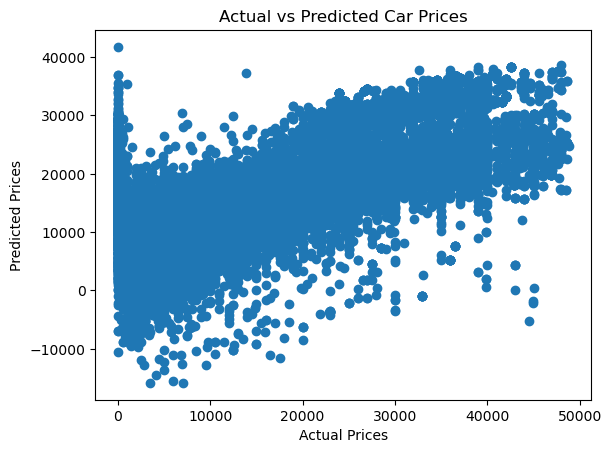

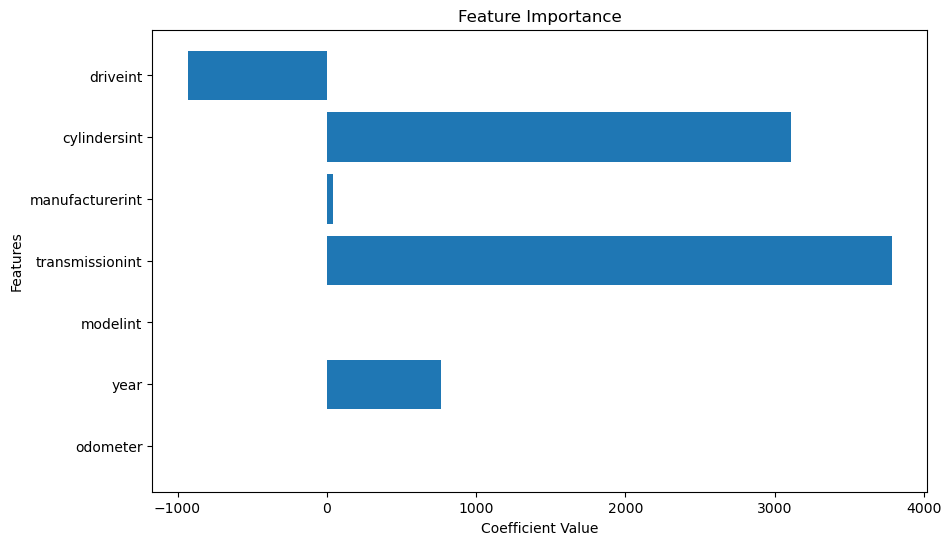

In [94]:
# Define relative absolute error function
def relative_absolute_error(y_true, y_pred):
    return np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(y_true - np.mean(y_true)))

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rae = relative_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-Squared: {r2}')
print(f'Relative Absolute Error: {rae}')

# Print the coefficients of the model
print('Coefficients:')
print(dict(zip(x.columns, multi_reg_model.coef_)))
#  Visualize actual vs predicted prices
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Car Prices')
plt.show()

plt.figure(figsize=(10,6))
plt.barh(x.columns, multi_reg_model.coef_)
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### The odometer reading has a negative coefficient of approximately -0.049, indicating that higher mileage typically decreases the car's price, as expected due to increased wear and tear. Conversely, the year of manufacture shows a positive coefficient of around 766.29, suggesting that newer cars command higher prices, which aligns with the perception that newer models are more desirable. Although the model number (encoded as modelint) has a very small positive coefficient, its impact on price is minimal. The transmission type (encoded as transmissionint) has a substantial positive coefficient of about 3785.77, highlighting that certain types of transmission, such as automatic, may significantly increase a car's value. The manufacturer's encoding also has a positive effect on price, albeit relatively small, with a coefficient of 38.84, reflecting slight variations in value based on brand reputation. The number of cylinders in the car's engine, with a coefficient of approximately 3111.19, suggests that cars with more cylinders, and therefore potentially higher performance, tend to have higher prices. Lastly, the drive type (encoded as driveint) has a negative coefficient of -933.26, implying that some drive types may reduce the car's price, possibly due to less favorable buyer preferences. These insights help us understand the relative importance of each feature in determining the price of a used car and guide future model improvements and data analyses.

#### Potential Improvements
Seeing as how the 3 most important features are cylinders, transmission, and year; we should train the model using those three params to further progress this model.



Coefficients:
{'year': 1066.7360696312219, 'transmissionint': 4877.618464262881, 'cylindersint': 3020.8282595366695}


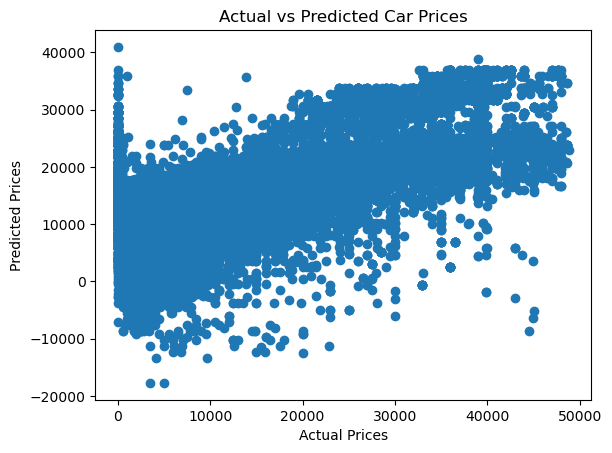

In [97]:
# Define features and target variable
x = newUsedCars[[ 'year', 'transmissionint',  'cylindersint']]
y = newUsedCars['price']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
# Initialize the multiple regression model
multi_reg_model = LinearRegression()

# Train the model
multi_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = multi_reg_model.predict(X_test)
# Define relative absolute error function
def relative_absolute_error(y_true, y_pred):
    return np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(y_true - np.mean(y_true)))

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rae = relative_absolute_error(y_test, y_pred)

# Print the coefficients of the model
print('Coefficients:')
print(dict(zip(x.columns, multi_reg_model.coef_)))
#  Visualize actual vs predicted prices
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Car Prices')
plt.show()



# -----------------------Ridge Regression (Michael)-------------------------

I will create and evaluate 3 models using Ridge Regression:
1. Year, odometer, manufactureint
2. Year, odometer, conditionint, driveint
3. All inputs

With these inputs varying, I hope to achieve some pattern to further understand the dataset.

# Year, odometer, manufactureint

In [101]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge

# Inputs (our X) are year, odometer, and conditionint in dataset
Inputs_1 = newUsedCars[["year", "odometer", "manufacturerint"]]

# Splitting dataset into training and testing
train_X_1, test_X_1, train_y_1, test_y_1 = train_test_split(
    Inputs_1, Price, test_size=0.2, random_state=42
)

# Scaled to normalize
scaler_1 = StandardScaler()
trainX_1_scaled = scaler_1.fit_transform(train_X_1)
testX_1_scaled = scaler_1.transform(test_X_1)

# Ridge reg step
ridge_1 = Ridge(alpha=1.0)
ridge_1.fit(trainX_1_scaled, train_y_1)
pred_y_1 = ridge_1.predict(testX_1_scaled)

## Evaluation

In [103]:
r_square_1 = r2_score(test_y_1, pred_y_1)
mean_absolute_1 = mean_absolute_error(test_y_1, pred_y_1)
root_mean_square_1 = np.sqrt(mean_squared_error(test_y_1, pred_y_1))
correlation_1 = np.corrcoef(test_y_1, pred_y_1)[0, 1]
relative_absolute_error_1 = (np.sum(np.abs(test_y_1 - pred_y_1)) /np.sum(np.abs(test_y_1 - np.mean(test_y_1))))

print("Model 1 with `year`, `odometer`, and `manufacturerint`:")
print("R-squared:", r_square_1)
print("Mean Absolute Error:", mean_absolute_1)
print("Root Mean Squared Error:", root_mean_square_1)
print("Correlation Coefficient:", correlation_1)
print("Relative Absolute Error:", relative_absolute_error_1)

Model 1 with `year`, `odometer`, and `manufacturerint`:
R-squared: 0.37804343016044084
Mean Absolute Error: 7203.142134244563
Root Mean Squared Error: 9303.86368967704
Correlation Coefficient: 0.6148718192867227
Relative Absolute Error: 0.7390722969060441


# Year, odometer, conditionint, driveint

In [105]:
# Inputs (our X) are year, odometer, conditionint, and driveint in dataset
Inputs_2 = newUsedCars[["year", "odometer", "conditionint", "driveint"]]

# Splitting dataset into training and testing
train_X_2, test_X_2, train_y_2, test_y_2 = train_test_split(
    Inputs_2, Price, test_size=0.2, random_state=42
)

# Scaled to normalize
scaler_2 = StandardScaler()
trainX_2_scaled = scaler_2.fit_transform(train_X_2)
testX_2_scaled = scaler_2.transform(test_X_2)

# Ridge reg step
ridge_2 = Ridge(alpha=1.0)
ridge_2.fit(trainX_2_scaled, train_y_2)
pred_y_2 = ridge_2.predict(testX_2_scaled)

## Evaluation

In [107]:
r_square_2 = r2_score(test_y_2, pred_y_2)
mean_absolute_2 = mean_absolute_error(test_y_2, pred_y_2)
root_mean_square_2 = np.sqrt(mean_squared_error(test_y_2, pred_y_2))
correlation_2 = np.corrcoef(test_y_2, pred_y_2)[0, 1]
relative_absolute_error_2 = (np.sum(np.abs(test_y_2 - pred_y_2)) /np.sum(np.abs(test_y_2 - np.mean(test_y_2))))

print("Model 2 with `year`, `odometer`, `conditionint`, and `driveint`:")
print("R-squared:", r_square_2)
print("Mean Absolute Error:", mean_absolute_2)
print("Root Mean Squared Error:", root_mean_square_2)
print("Correlation Coefficient:", correlation_2)
print("Relative Absolute Error:", relative_absolute_error_2)

Model 2 with `year`, `odometer`, `conditionint`, and `driveint`:
R-squared: 0.3921552507457656
Mean Absolute Error: 7103.46653497115
Root Mean Squared Error: 9197.708549355037
Correlation Coefficient: 0.6262429829304209
Relative Absolute Error: 0.7288451664777462


# All inputs

In [109]:
# Inputs (our X) is all inputs in dataset
Inputs = newUsedCars[["year", "manufacturerint", "conditionint", "cylindersint", "odometer",
                 "title_statusint", "transmissionint", "driveint", "typeint"]]

# Our target variable, Price
Price = newUsedCars["price"]

# Splitting dataset into training and testing
train_X, test_X, train_y, test_y = train_test_split(Inputs, Price, test_size=0.2, random_state=42)

# Scaled to normalize
scaler = StandardScaler()
trainX_scaled = scaler.fit_transform(train_X)
testX_scaled = scaler.transform(test_X)

# Ridge reg step
ridge = Ridge(alpha=1.0) 
ridge.fit(trainX_scaled, train_y)
pred_y = ridge.predict(testX_scaled)

## Evaluation

In [111]:
r_square = r2_score(test_y, pred_y)
mean_absolute = mean_absolute_error(test_y, pred_y)
root_mean_square = np.sqrt(mean_squared_error(test_y, pred_y))
correlation = np.corrcoef(test_y, pred_y)[0, 1] 
relative_absolute_error = np.sum(np.abs(test_y - pred_y)) / np.sum(np.abs(test_y - np.mean(test_y)))

print("Model 3 with all inputs:")
print("R-squared:", r_square)
print("Mean Absolute Error:", mean_absolute)
print("Root Mean Squared Error:", root_mean_square)
print("Correlation Coefficient:", correlation)
print("Relative Absolute Error:", relative_absolute_error)

Model 3 with all inputs:
R-squared: 0.5498832742642276
Mean Absolute Error: 5499.771600220672
Root Mean Squared Error: 7914.908245368028
Correlation Coefficient: 0.7415502738737887
Relative Absolute Error: 0.5642994061868549


## Conclusions

* For model 1, we have relatively high MAE and RMSE, so this model was middling in terms of accuracy
* The coefficient of 0.614 in model 1 shows a moderate positive relationship between the predictions and target.
* For model 2, the R-squared value improved slightly, as well as the MAE and RMSE values being lower.
* Additionally, the coefficient is slightly higher.
* Finally, when looking at the model with all inputs, R-squared improves greatly, as well as the MAE and RMSE being much lower, which indicates better accuracy.
* Also, the coefficient improves to 0.742, showing a positive relationship.

Overall, in my exploration with Ridge Regression, I found that the model with all inputs should be used when making predictions because it provides the most accurate results.